In [109]:
'''
exploratory_analysis.ipynb

1. count of emails, by email account
        broken down by (to, from, total) X (external, internal, overall)
        input: df_20_features.csv, rows = 103480, 20% of original enron dataset, is_external feature added
        output: email_count.csv
2. Wordcloud of body and subject (external, internal, overall)
        input: df_test.csv, rows = 25870, 25% of df_20_features.csv (5% of original enron dataset)
3. tfidf analysis, body (external, internal, overall)
        input: df_test2.csv, rows = 6467, 25% of df_test.csv (1.25% of original enron dataset)
4. tfidf analysis, body (external, internal, overall)
        input: df_test2_subject_cleaned.csv, rows = 6235, null subjects removed from df_test2.csv

Summary:

1. From the count of emails analysis, two aspects stood out. First, there was quite a spread of email counts by email 
address. Given that the dataset came from a limited number of Enron executives. Second, amongst the top 50 (by count) email 
addresses, the percentage of external email varies (with most being below 50%). Tha is also not suprising, given the 
different roles within Erno.

2., 3., and 4. The main aspect I was exporing was the possible difference between internal and external email. My 
speculation is that the style of communication in the booy should differ across internal and external communications. Also,
the subjects of the emails might differ internally and externall. The wordcloud and tfidf analysis suggest that some 
differences might be there.
'''


'\nexploratory_analysis.py\n\n1. count of emails, by email account\n        broken down by (to, from, total) X (external, internal, overall)\n        input: df_20_features.csv, rows = 103480, 20% of original enron dataset, is_external feature added\n        output: email_count.csv\n2. Wordcloud of body and subject (external, internal, overall)\n        input: df_test.csv, rows = 25870, 25% of df_20_features.csv (5% of original enron dataset)\n3. tfidf analysis, body (external, internal, overall)\n        input: df_test2.csv, rows = 6467, 25% of df_test.csv (1.25% of original enron dataset)\n4. tfidf analysis, body (external, internal, overall)\n        input: df_test2_subject_cleaned.csv, rows = 6235, null subjects removed from df_test2.csv\n\nSummary:\n\n1. From the count of emails analysis, two aspects stood out. First, there was quite a spread of email counts by email \naddress. Given that the dataset came from a limited number of Enron executives. Second, amongst the top 50 (by cou

In [110]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import math
import sys
import copy
import sklearn
import nltk
import re
import email
import random


In [111]:
# read in data
df_20_features = pd.read_csv('df_20_features.csv')
print(df_20_features.shape)
print(df_20_features.columns)


(103480, 13)
Index(['index_orig', 'file', 'message', 'email_to', 'email_from', 'cc', 'bcc',
       'subject', 'x_from', 'x_to', 'date_sent', 'body', 'is_external'],
      dtype='object')


In [112]:
#
# quick look of the dataset characteristics
#

In [113]:
print(df_20_features['is_external'].value_counts())


False    69136
True     34335
Name: is_external, dtype: int64


In [114]:
df_20_features['date_sent'] = pd.to_datetime(df_20_features['date_sent'])


In [115]:
print(min(df_20_features['date_sent']))
print(max(df_20_features['date_sent']))


1979-12-31 16:00:00-08:00
2044-01-04 08:59:46-08:00


In [116]:
print(df_20_features['email_to'].value_counts().iloc[0:50])


pete.davis@enron.com          1888
tana.jones@enron.com          1243
jeff.dasovich@enron.com       1172
steven.kean@enron.com         1159
sara.shackleton@enron.com     1149
vkaminski@aol.com             1022
mark.taylor@enron.com          892
kay.mann@enron.com             783
kate.symes@enron.com           717
sally.beck@enron.com           694
gerald.nemec@enron.com         692
richard.shapiro@enron.com      692
vince.kaminski@enron.com       685
louise.kitchen@enron.com       683
all.worldwide@enron.com        623
daren.farmer@enron.com         608
kenneth.lay@enron.com          543
benjamin.rogers@enron.com      510
alan.comnes@enron.com          487
john.lavorato@enron.com        442
suzanne.adams@enron.com        432
chris.germany@enron.com        416
alan.aronowitz@enron.com       410
all.houston@enron.com          402
tim.belden@enron.com           347
klay@enron.com                 340
skean@enron.com                334
shirley.crenshaw@enron.com     314
james.steffes@enron.

In [117]:
print(df_20_features['email_from'].value_counts().iloc[0:50])


kay.mann@enron.com               3387
vince.kaminski@enron.com         2883
jeff.dasovich@enron.com          2322
pete.davis@enron.com             1886
chris.germany@enron.com          1762
sara.shackleton@enron.com        1737
tana.jones@enron.com             1694
enron.announcements@enron.com    1692
steven.kean@enron.com            1351
matthew.lenhart@enron.com        1085
kate.symes@enron.com             1081
eric.bass@enron.com              1022
no.address@enron.com              991
sally.beck@enron.com              897
debra.perlingiere@enron.com       885
mark.taylor@enron.com             829
susan.scott@enron.com             808
gerald.nemec@enron.com            796
drew.fossum@enron.com             736
benjamin.rogers@enron.com         704
john.arnold@enron.com             701
carol.clair@enron.com             687
david.delainey@enron.com          657
richard.sanders@enron.com         653
darron.giron@enron.com            592
phillip.love@enron.com            587
daren.farmer

In [118]:
#
# 1. count of emails, by email account
#        broken down by (to, from, total) X (external, internal, overall)
#        input: df_20_features.csv, rows = 103480, 20% of original enron dataset, is_external feature added
#        output: email_count.csv
#


In [119]:
# counts of 'To' emails, by email address, creating email_to_count

email_to_count = df_20_features['email_to'].value_counts()
email_to_count = email_to_count.reset_index()
email_to_count.columns = ['email', 'to_count']
print(email_to_count.shape)
print(email_to_count.columns)


(11127, 2)
Index(['email', 'to_count'], dtype='object')


In [120]:
# counts of 'From' emails, by email address, creating email_from_count

email_from_count = df_20_features['email_from'].value_counts()
email_from_count = email_from_count.reset_index()
email_from_count.columns = ['email', 'from_count']
print(email_from_count.shape)
print(email_from_count.columns)


(10307, 2)
Index(['email', 'from_count'], dtype='object')


In [121]:
# join email_to_count and email_from_count into email_count

email_count = email_to_count.merge(email_from_count, how = 'outer', on = 'email')
print(email_count.shape)
print(email_count.columns)
email_count.fillna(0, inplace = True)


(16768, 3)
Index(['email', 'to_count', 'from_count'], dtype='object')


In [122]:
# calculate 'total_count'

email_count['total_count'] = email_count['to_count'] + email_count['from_count']


In [123]:
# quick look at email count, sorted by total_count,

print(email_count.sort_values('total_count', ascending = False).iloc[0:50])
      

                               email  to_count  from_count  total_count
7                 kay.mann@enron.com     783.0      3387.0       4170.0
0               pete.davis@enron.com    1888.0      1886.0       3774.0
12          vince.kaminski@enron.com     685.0      2883.0       3568.0
2            jeff.dasovich@enron.com    1172.0      2322.0       3494.0
1               tana.jones@enron.com    1243.0      1694.0       2937.0
4          sara.shackleton@enron.com    1149.0      1737.0       2886.0
3              steven.kean@enron.com    1159.0      1351.0       2510.0
21           chris.germany@enron.com     416.0      1762.0       2178.0
8               kate.symes@enron.com     717.0      1081.0       1798.0
6              mark.taylor@enron.com     892.0       829.0       1721.0
11127  enron.announcements@enron.com       0.0      1692.0       1692.0
9               sally.beck@enron.com     694.0       897.0       1591.0
10            gerald.nemec@enron.com     692.0       796.0      

In [124]:
# add internal/external buckets


In [125]:
print(df_20_features.shape)
print(df_20_features.columns)


(103480, 13)
Index(['index_orig', 'file', 'message', 'email_to', 'email_from', 'cc', 'bcc',
       'subject', 'x_from', 'x_to', 'date_sent', 'body', 'is_external'],
      dtype='object')


In [126]:
print(email_count.shape)
print(email_count.columns)


(16768, 4)
Index(['email', 'to_count', 'from_count', 'total_count'], dtype='object')


In [127]:
external_state_list = [True, False]
cols = ['email_to', 'email_from']

for external_state in external_state_list: # loop for is_external True and False

    #subset df_20_features into df_temp
    df_temp = df_20_features[df_20_features['is_external'] == external_state]
    print(df_temp.shape)
    
    for col in cols: # loop for cols in df_temp
        
        # figure out name of new column in email count
        new_col = col.split('_')[1]
        if external_state == True:
            new_col = new_col + '_ext_count'
        else:
            new_col = new_col + '_int_count'
        
        # do count, put into email_temp
        email_temp = df_temp[col].value_counts()
        email_temp = email_temp.reset_index()
        email_temp.columns = ['email', new_col]
        print(email_temp.shape)
        print(email_temp.columns)
        
        # join with email count, replace nulls with 0
        email_count = email_count.merge(email_temp, how = 'outer', on = 'email')
        email_count.fillna(0, inplace = True)


(34335, 13)
(6423, 2)
Index(['email', 'to_ext_count'], dtype='object')
(6810, 2)
Index(['email', 'from_ext_count'], dtype='object')
(69136, 13)
(5180, 2)
Index(['email', 'to_int_count'], dtype='object')
(4174, 2)
Index(['email', 'from_int_count'], dtype='object')


In [128]:
print(email_count.shape)
print(email_count.columns)


(16768, 8)
Index(['email', 'to_count', 'from_count', 'total_count', 'to_ext_count',
       'from_ext_count', 'to_int_count', 'from_int_count'],
      dtype='object')


In [129]:
# calculate total_ext_count and total_int_count

email_count['total_ext_count'] = email_count['to_ext_count'] + email_count['from_ext_count']
email_count['total_int_count'] = email_count['to_int_count'] + email_count['from_int_count']


In [130]:
# look at total_int_count, all columns

print(email_count.sort_values('total_int_count', ascending = False).iloc[0:50])


                               email  to_count  from_count  total_count  \
0               pete.davis@enron.com    1888.0      1886.0       3774.0   
7                 kay.mann@enron.com     783.0      3387.0       4170.0   
1               tana.jones@enron.com    1243.0      1694.0       2937.0   
2            jeff.dasovich@enron.com    1172.0      2322.0       3494.0   
4          sara.shackleton@enron.com    1149.0      1737.0       2886.0   
3              steven.kean@enron.com    1159.0      1351.0       2510.0   
12          vince.kaminski@enron.com     685.0      2883.0       3568.0   
8               kate.symes@enron.com     717.0      1081.0       1798.0   
11127  enron.announcements@enron.com       0.0      1692.0       1692.0   
21           chris.germany@enron.com     416.0      1762.0       2178.0   
6              mark.taylor@enron.com     892.0       829.0       1721.0   
9               sally.beck@enron.com     694.0       897.0       1591.0   
15            daren.farme

In [131]:
# look at total_ext_count, all columns

print(email_count.sort_values('total_ext_count', ascending = False).iloc[0:50])


                                     email  to_count  from_count  total_count  \
12                vince.kaminski@enron.com     685.0      2883.0       3568.0   
7                       kay.mann@enron.com     783.0      3387.0       4170.0   
5                        vkaminski@aol.com    1022.0       107.0       1129.0   
2                  jeff.dasovich@enron.com    1172.0      2322.0       3494.0   
11128                 no.address@enron.com       0.0       991.0        991.0   
99               matthew.lenhart@enron.com     137.0      1085.0       1222.0   
21                 chris.germany@enron.com     416.0      1762.0       2178.0   
4                sara.shackleton@enron.com    1149.0      1737.0       2886.0   
17               benjamin.rogers@enron.com     510.0       704.0       1214.0   
1093                     40enron@enron.com      15.0       500.0        515.0   
10                  gerald.nemec@enron.com     692.0       796.0       1488.0   
1                     tana.j

In [132]:
# look at total_int_count, subset of columns

cols = ['email', 'total_count', 'total_int_count', 'total_ext_count']
print(email_count[cols].sort_values('total_int_count', ascending = False).iloc[0:50])


                               email  total_count  total_int_count  \
0               pete.davis@enron.com       3774.0           3774.0   
7                 kay.mann@enron.com       4170.0           2797.0   
1               tana.jones@enron.com       2937.0           2528.0   
2            jeff.dasovich@enron.com       3494.0           2459.0   
4          sara.shackleton@enron.com       2886.0           2322.0   
3              steven.kean@enron.com       2510.0           2296.0   
12          vince.kaminski@enron.com       3568.0           2132.0   
8               kate.symes@enron.com       1798.0           1693.0   
11127  enron.announcements@enron.com       1692.0           1691.0   
21           chris.germany@enron.com       2178.0           1581.0   
6              mark.taylor@enron.com       1721.0           1460.0   
9               sally.beck@enron.com       1591.0           1434.0   
15            daren.farmer@enron.com       1183.0           1112.0   
10            gerald

In [133]:
# look at total_ext_count, subset of columns

cols = ['email', 'total_count', 'total_int_count', 'total_ext_count']
print(email_count[cols].sort_values('total_ext_count', ascending = False).iloc[0:50])


                                     email  total_count  total_int_count  \
12                vince.kaminski@enron.com       3568.0           2132.0   
7                       kay.mann@enron.com       4170.0           2797.0   
5                        vkaminski@aol.com       1129.0              0.0   
2                  jeff.dasovich@enron.com       3494.0           2459.0   
11128                 no.address@enron.com        991.0             56.0   
99               matthew.lenhart@enron.com       1222.0            468.0   
21                 chris.germany@enron.com       2178.0           1581.0   
4                sara.shackleton@enron.com       2886.0           2322.0   
17               benjamin.rogers@enron.com       1214.0            693.0   
1093                     40enron@enron.com        515.0             30.0   
10                  gerald.nemec@enron.com       1488.0           1053.0   
1                     tana.jones@enron.com       2937.0           2528.0   
55          

In [134]:
# calculate percent_ext

email_count['percent_ext'] = 100.0*email_count['total_ext_count']/email_count['total_count']


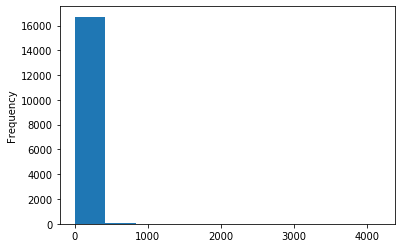

In [135]:
# histogram of total_count

email_count['total_count'].plot.hist()


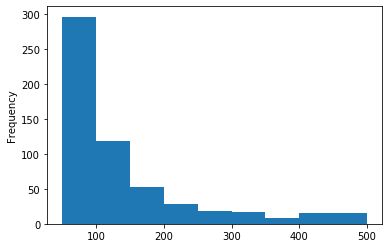

In [136]:
# histogram of total_count, focusing on first bin of previous histogram

bin_list = [50,100,150,200,250,300,350,400,500]
email_count['total_count'].plot.hist(bins = bin_list)


In [137]:
# percent_ext for the top 50 email addresses, by count

cols = ['email', 'total_count', 'percent_ext']
print(email_count[cols].sort_values('total_count', ascending = False).iloc[0:50])


                               email  total_count  percent_ext
7                 kay.mann@enron.com       4170.0    32.925659
0               pete.davis@enron.com       3774.0     0.000000
12          vince.kaminski@enron.com       3568.0    40.246637
2            jeff.dasovich@enron.com       3494.0    29.622210
1               tana.jones@enron.com       2937.0    13.925775
4          sara.shackleton@enron.com       2886.0    19.542620
3              steven.kean@enron.com       2510.0     8.525896
21           chris.germany@enron.com       2178.0    27.410468
8               kate.symes@enron.com       1798.0     5.839822
6              mark.taylor@enron.com       1721.0    15.165601
11127  enron.announcements@enron.com       1692.0     0.059102
9               sally.beck@enron.com       1591.0     9.868008
10            gerald.nemec@enron.com       1488.0    29.233871
99         matthew.lenhart@enron.com       1222.0    61.702128
17         benjamin.rogers@enron.com       1214.0    42

In [138]:
#
# 2. Wordcloud of body and subject (external, internal, overall)
#        input: df_test.csv, rows = 25870, 25% of df_20_features.csv (5% of original enron dataset)
#


In [139]:
from wordcloud import WordCloud, STOPWORDS


In [140]:
# create df_test, 25% of df_20_features

# size of df_test
new_size = round(int(df_20_features.shape[0] *0.25))
print(new_size)

# pick random indices
new_ind = random.sample(range(0, df_20_features.shape[0]), new_size)

# create df_20
df_test = df_20_features.iloc[new_ind]
print(df_test.shape)
print(df_test.columns)


25870
(25870, 13)
Index(['index_orig', 'file', 'message', 'email_to', 'email_from', 'cc', 'bcc',
       'subject', 'x_from', 'x_to', 'date_sent', 'body', 'is_external'],
      dtype='object')


In [141]:
# function to create wordclouds

def create_wordcloud(df_temp, field):
    comment_words = ''
    stopwords = set(STOPWORDS)

    # iterate through the csv file
    for val in df_temp[field]:

        # typecast each val to string
        val = str(val)

        # split the value
        tokens = val.split()

        # Converts each token into lowercase
        for i in range(len(tokens)):
            tokens[i] = tokens[i].lower()

        comment_words += " ".join(tokens)+" "

    wordcloud = WordCloud(width = 800, height = 800,
                    background_color ='white',
                    stopwords = stopwords,
                    min_font_size = 10).generate(comment_words)

    # plot the WordCloud image                      
    plt.figure(figsize = (8, 8), facecolor = None)
    plt.imshow(wordcloud)


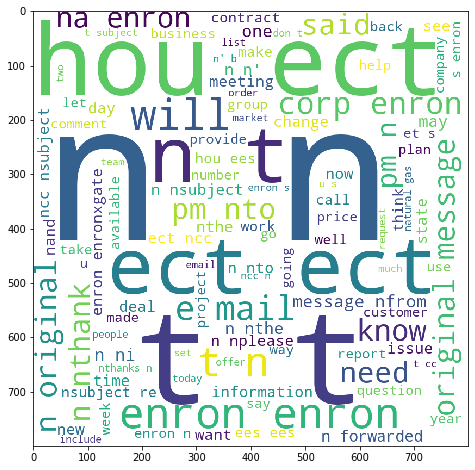

In [142]:
# wordcloud of body, overall

field = 'body'
df_temp = df_test
create_wordcloud(df_temp, field)


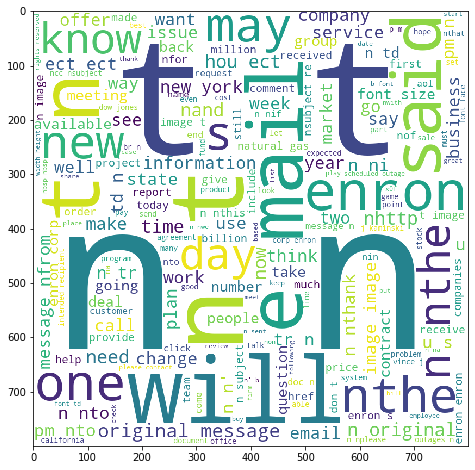

In [143]:
# wordcloud of body, external

field = 'body'
df_temp = df_test[df_test['is_external'] == True]
create_wordcloud(df_temp, field)


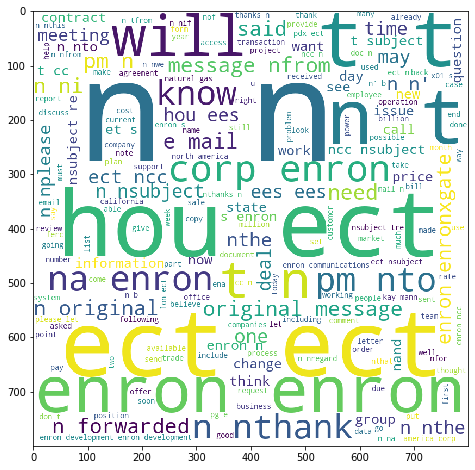

In [144]:
# wordcloud of body, internal

field = 'body'
df_temp = df_test[df_test['is_external'] == False]
create_wordcloud(df_temp, field)


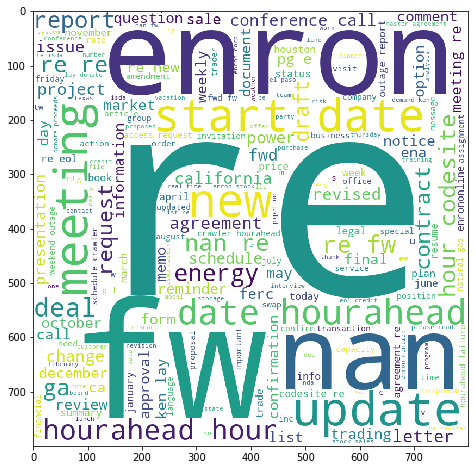

In [145]:
field = 'subject'
df_temp = df_test
create_wordcloud(df_temp, field)


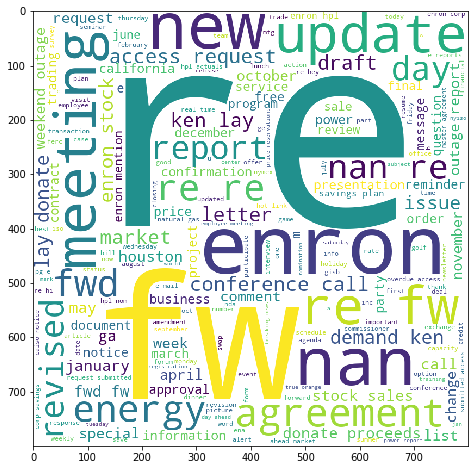

In [146]:
# wordcloud of subject, overall

field = 'subject'
df_temp = df_test[df_test['is_external'] == True]
create_wordcloud(df_temp, field)


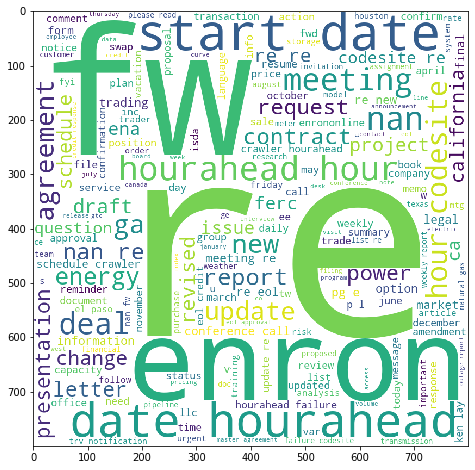

In [147]:
# wordcloud of subject, external

field = 'subject'
df_temp = df_test[df_test['is_external'] == False]
create_wordcloud(df_temp, field)


In [148]:
#
# 3. tfidf analysis, body (external, internal, overall)
#        input: df_test2.csv, rows = 6467, 25% of df_test.csv (1.25% of original enron dataset)
# from 
# https://towardsdatascience.com/how-i-used-machine-learning-to-classify-emails-and-turn-them-into-insights-efed37c1e66
#


In [149]:
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD 
from sklearn.preprocessing import normalize 


In [150]:
# funtions to look at tfidf results

def top_tfidf_feats(row, features, top_n=20):
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats, columns=['features', 'score'])
    return df

def top_feats_in_doc(X, features, row_id, top_n=25):
    row = np.squeeze(X[row_id].toarray())
    return top_tfidf_feats(row, features, top_n)


In [151]:
print(df_test.shape)
print(df_test.columns)


(25870, 13)
Index(['index_orig', 'file', 'message', 'email_to', 'email_from', 'cc', 'bcc',
       'subject', 'x_from', 'x_to', 'date_sent', 'body', 'is_external'],
      dtype='object')


In [152]:
# create df_test2, 25% of df_test

# size of df_test2.csv
new_size = round(int(df_test.shape[0] *0.25))
print(new_size)

# pick random indices
new_ind = random.sample(range(0, df_test.shape[0]), new_size)

# create df_20
df_test2 = df_test.iloc[new_ind]
print(df_test2.shape)
print(df_test2.columns)


6467
(6467, 13)
Index(['index_orig', 'file', 'message', 'email_to', 'email_from', 'cc', 'bcc',
       'subject', 'x_from', 'x_to', 'date_sent', 'body', 'is_external'],
      dtype='object')


In [153]:
# function for tfidf analysis

def tfidf_analysis(df, field):
    
    # do tfidf vectorization on field (body or subject, in this case)
    vect = TfidfVectorizer(stop_words='english', max_df=0.500, min_df=2)
    X = vect.fit_transform(df[field])
    print('---')
    print(X.shape)
    print('---')
    
    # visualize in 2D using PCA
    X_dense = X.todense()
    coords = PCA(n_components=2).fit_transform(X_dense)
    plt.scatter(coords[:, 0], coords[:, 1], c='m')
    plt.show()

    # print out top 50 features
    features = vect.get_feature_names()
    print(top_feats_in_doc(X, features, 1, 50))


---
(6467, 34378)
---


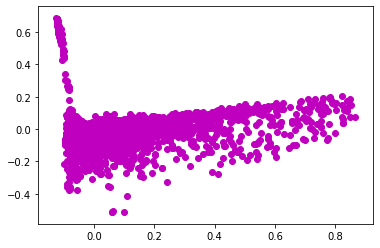

        features     score
0             uh  0.301979
1        praveen  0.284174
2          bauer  0.277829
3        seminar  0.269338
4          kumar  0.221992
5            743  0.208372
6            edu  0.208131
7        college  0.202009
8          vince  0.184683
9        finance  0.142546
10           com  0.140079
11       winmail  0.133908
12           dat  0.130025
13        floors  0.121847
14          6021  0.113232
15      npraveen  0.113232
16       melcher  0.113232
17          4789  0.113232
18         77204  0.113232
19       darrell  0.110337
20         enron  0.109051
21          4770  0.104186
22     professor  0.103470
23      kaminski  0.095594
24        friday  0.090868
25         lunch  0.088457
26       january  0.088189
27          2002  0.086410
28      thursday  0.082455
29        arthur  0.082339
30       trading  0.078325
31     recipient  0.077046
32       houston  0.075885
33           713  0.072170
34           334  0.068116
35          week  0.067323
3

In [154]:
# tfidf body, overall

tfidf_analysis(df_test2, 'body')


---
(2131, 20549)
---


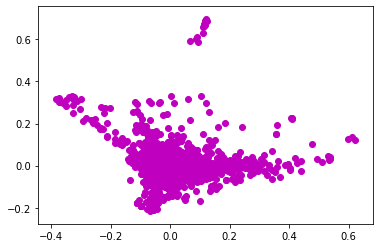

                                             features     score
0                                            explorer  0.497308
1                                                 msn  0.440098
2                                                1200  0.354211
3                                              backup  0.283797
4                                                intl  0.263120
5   n_____________________________________________...  0.263120
6                                            download  0.227551
7                                                nget  0.201622
8                                                 asp  0.185932
9                                                  09  0.172028
10                                               free  0.146767
11                                                 12  0.135498
12                                               http  0.134290
13                                               gala  0.000000
14                                      

In [155]:
# tfidf body, external

tfidf_analysis(df_test2[df_test2['is_external'] == True], 'body')


---
(4336, 23895)
---


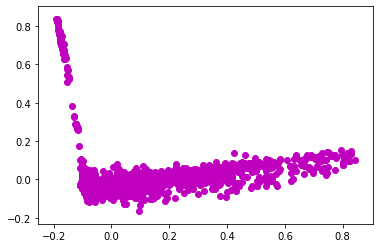

       features     score
0          pget  0.530479
1        avista  0.335306
2           ect  0.279481
3          wire  0.174591
4           hou  0.161847
5         tracy  0.150709
6         sager  0.150196
7     documents  0.123655
8   transaction  0.122121
9    telizabeth  0.111769
10          115  0.111769
11    njklauber  0.111769
12          ees  0.106303
13         6349  0.106096
14          854  0.106096
15        final  0.104958
16          714  0.103939
17  ncollateral  0.103939
18   signatures  0.100423
19    nremember  0.095278
20      ntravis  0.094241
21    everybody  0.093276
22          713  0.092980
23        yoder  0.087918
24   mccullough  0.087296
25         llgm  0.087296
26    christian  0.085052
27       travis  0.084053
28     checking  0.081827
29    gathering  0.081827
30        vicki  0.081422
31      happens  0.081422
32    signature  0.080644
33        sharp  0.080644
34      tonight  0.079553
35          t12  0.078871
36     bradford  0.077598
37          

In [156]:
# tfidf body, internal

tfidf_analysis(df_test2[df_test2['is_external'] == False], 'body')


In [157]:
#
# 4. tfidf analysis, body (external, internal, overall)
#        input: df_test2_subject_cleaned.csv, rows = 6235, null subjects removed from df_test2.csv
#


In [158]:
# clean subjects of nulls, create df_test2_clean_subject

print(df_test2.shape)
df_test2_clean_subject = df_test2.dropna(subset =['subject'])
print(df_test2_clean_subject.shape)


(6467, 13)
(6241, 13)


---
(6241, 2483)
---


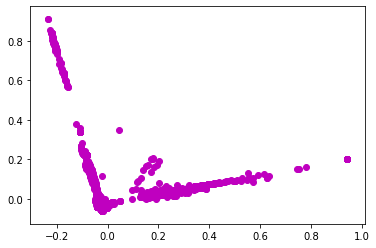

        features     score
0          visit  0.611959
1          lunch  0.589111
2           week  0.527688
3         espeak  0.000000
4        esource  0.000000
5         escrow  0.000000
6            esa  0.000000
7            erv  0.000000
8         errors  0.000000
9          error  0.000000
10          zone  0.000000
11          eric  0.000000
12          eren  0.000000
13         ercot  0.000000
14        equity  0.000000
15     equitrans  0.000000
16          epsa  0.000000
17          eprm  0.000000
18          epmi  0.000000
19          erms  0.000000
20        estate  0.000000
21    essentials  0.000000
22            ep  0.000000
23      exchange  0.000000
24           ews  0.000000
25     evergreen  0.000000
26        events  0.000000
27         event  0.000000
28       evening  0.000000
29    evaluation  0.000000
30       eurotop  0.000000
31      european  0.000000
32        europe  0.000000
33           ets  0.000000
34        ethink  0.000000
35           eta  0.000000
3

In [159]:
# subject, overall

tfidf_analysis(df_test2_clean_subject, 'subject')


---
(2053, 1066)
---


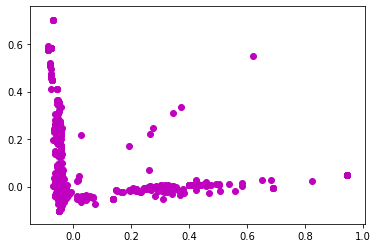

      features     score
0         1000  0.778874
1      reports  0.627180
2       zisman  0.000000
3     facility  0.000000
4      expedia  0.000000
5      expense  0.000000
6     exposure  0.000000
7        extra  0.000000
8        exxon  0.000000
9      failure  0.000000
10     exhibit  0.000000
11        fall  0.000000
12     fantasy  0.000000
13       fares  0.000000
14         feb  0.000000
15    february  0.000000
16     federal  0.000000
17   expansion  0.000000
18   execution  0.000000
19   executive  0.000000
20        ferc  0.000000
21   exclusive  0.000000
22    exchange  0.000000
23      events  0.000000
24       event  0.000000
25     evening  0.000000
26     eurotop  0.000000
27    european  0.000000
28      europe  0.000000
29      ethink  0.000000
30         eta  0.000000
31      estate  0.000000
32     esource  0.000000
33      escrow  0.000000
34    feedback  0.000000
35        fest  0.000000
36       ercot  0.000000
37        file  0.000000
38         fwd  0.000000


In [160]:
# subject, external

tfidf_analysis(df_test2_clean_subject[df_test2_clean_subject['is_external'] == True], 'subject')


---
(4188, 1794)
---


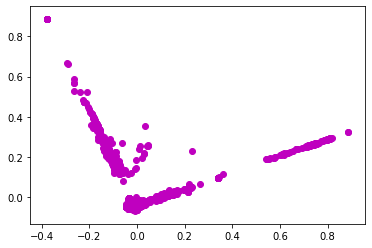

         features     score
0     transaction  0.619323
1       documents  0.587440
2           final  0.520916
3            zone  0.000000
4         enfolio  0.000000
5          engage  0.000000
6      engagement  0.000000
7     engineering  0.000000
8         enovate  0.000000
9         enpower  0.000000
10         enpwer  0.000000
11     enrollment  0.000000
12          enron  0.000000
13    enroncredit  0.000000
14    enrononline  0.000000
15        entered  0.000000
16            ene  0.000000
17        entergy  0.000000
18          entex  0.000000
19         entity  0.000000
20        entouch  0.000000
21          entry  0.000000
22    environment  0.000000
23  environmental  0.000000
24            enw  0.000000
25            eol  0.000000
26             ep  0.000000
27            epe  0.000000
28         energy  0.000000
29           ends  0.000000
30           epsa  0.000000
31            ehs  0.000000
32      edgecombe  0.000000
33         edison  0.000000
34      editorial  0

In [161]:
# subject, internal

tfidf_analysis(df_test2_clean_subject[df_test2_clean_subject['is_external'] == False], 'subject')


In [162]:
# 
# write dfs to csvs
#


In [163]:
df_test.to_csv('df_test.csv', index = False)
df_test2.to_csv('df_test2.csv', index = False)
df_test2_clean_subject.to_csv('df_test2_clean_subject.csv', index = False)
email_count.to_csv('email_count.csv', index = False)
